In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.utils import to_categorical

2024-06-26 02:33:30.595097: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-26 02:33:30.633212: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 02:33:31.280245: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Define a function to load and preprocess images and annotations
def load_and_preprocess_image(img_path, ann_path):
    img_path = img_path.numpy().decode('utf-8')
    ann_path = ann_path.numpy().decode('utf-8')
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 64))
    ann = cv2.imread(ann_path, 0)
    ann = cv2.resize(ann, (128, 64), interpolation=cv2.INTER_NEAREST)
    
    ann = np.clip(ann, 0, 29)
    ann = to_categorical(ann, num_classes=30)
    
    return img.astype(np.float32) / 255.0, ann.astype(np.float32)

In [3]:
# Define a function to create a TensorFlow dataset
def create_tf_dataset(image_files, annotation_files, batch_size):
    def parse_function(img_path, ann_path):
        img, ann = tf.py_function(
            load_and_preprocess_image, 
            [img_path, ann_path], 
            [tf.float32, tf.float32]
        )
        img.set_shape((64, 128, 3))
        ann.set_shape((64, 128, 30))
        return img, ann
    
    dataset = tf.data.Dataset.from_tensor_slices((image_files, annotation_files))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [4]:
# Define the U-Net architecture
def unet(input_size=(64, 128, 3), n_filters=16, n_classes=30):
    inputs = Input(input_size)
    conv1 = Conv2D(n_filters, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(n_filters, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(n_filters*2, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(n_filters*2, 3, activation='relu', padding='same')(conv2)
    up1 = Conv2DTranspose(n_filters, 3, strides=(2, 2), padding='same')(conv2)
    merge1 = concatenate([conv1, up1], axis=3)
    conv3 = Conv2D(n_filters, 3, activation='relu', padding='same')(merge1)
    conv3 = Conv2D(n_filters, 3, activation='relu', padding='same')(conv3)
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(conv3)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [5]:
# Function to match image files with annotation files
def get_matched_files(image_dir, annotation_dir, img_suffix='_leftImg8bit.png', ann_suffix='_gtFine_color.png'):
    image_files = {}
    annotation_files = {}
    for dirpath, _, filenames in os.walk(image_dir):
        for filename in filenames:
            if filename.endswith(img_suffix):
                base_name = filename.replace(img_suffix, '')
                full_path = os.path.join(dirpath, filename)
                image_files[base_name] = full_path
    for dirpath, _, filenames in os.walk(annotation_dir):
        for filename in filenames:
            if filename.endswith(ann_suffix):
                base_name = filename.replace(ann_suffix, '')
                full_path = os.path.join(dirpath, filename)
                annotation_files[base_name] = full_path
    matched_images = []
    matched_annotations = []
    for base_name, img_path in image_files.items():
        ann_path = annotation_files.get(base_name)
        if ann_path:
            matched_images.append(img_path)
            matched_annotations.append(ann_path)
        else:
            print(f"Warning: No matching annotation file for {img_path}")
    return matched_images, matched_annotations

# Main setup for training
image_dir = '/home/maith/Desktop/Cityscapes/leftImg8bit_trainvaltest/train'
annotation_dir = '/home/maith/Desktop/Cityscapes/gtFine_trainvaltest/train'
image_files, annotation_files = get_matched_files(image_dir, annotation_dir)
train_dataset = create_tf_dataset(image_files, annotation_files, batch_size=2)

# Initialize and compile the model
model = unet(input_size=(64, 128, 3), n_filters=16, n_classes=30)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_dataset, epochs=10, verbose=1)

# Save the model
model.save('cityScapes.keras')

Epoch 1/10


2024-06-26 02:33:33.089550: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2024-06-26 02:33:33.089592: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:134] retrieving CUDA diagnostic information for host: debian
2024-06-26 02:33:33.089598: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:141] hostname: debian
2024-06-26 02:33:33.089710: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:165] libcuda reported version is: 555.42.2
2024-06-26 02:33:33.089734: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:169] kernel reported version is: 555.42.2
2024-06-26 02:33:33.089739: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:248] kernel version seems to match DSO: 555.42.2


1488/1488 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.8667 - loss: 0.5967
Epoch 2/10
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 44s 30ms/step - accuracy: 0.9088 - loss: 0.2790
Epoch 3/10
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 48s 32ms/step - accuracy: 0.9175 - loss: 0.2546
Epoch 4/10
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 49s 33ms/step - accuracy: 0.9245 - loss: 0.2350
Epoch 5/10
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 53s 35ms/step - accuracy: 0.9299 - loss: 0.2206
Epoch 6/10
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 60s 40ms/step - accuracy: 0.9337 - loss: 0.2101
Epoch 7/10
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 61s 40ms/step - accuracy: 0.9369 - loss: 0.2014
Epoch 8/10
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 53s 36ms/step - accuracy: 0.9393 - loss: 0.1953
Epoch 9/10
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.9409 - loss: 0.1908
Epoch 10/10
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 55s 37ms/step - accuracy: 0.9424 - loss: 0.1866


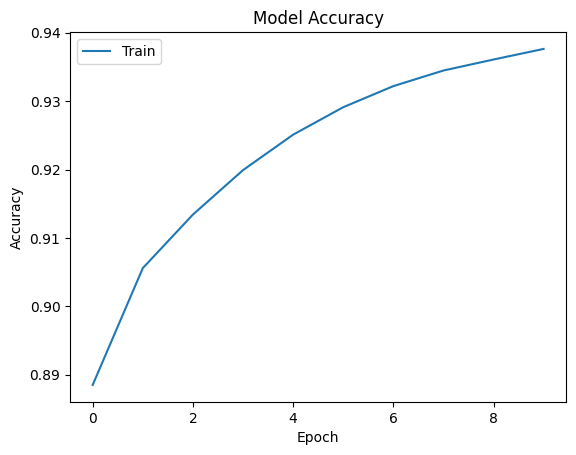

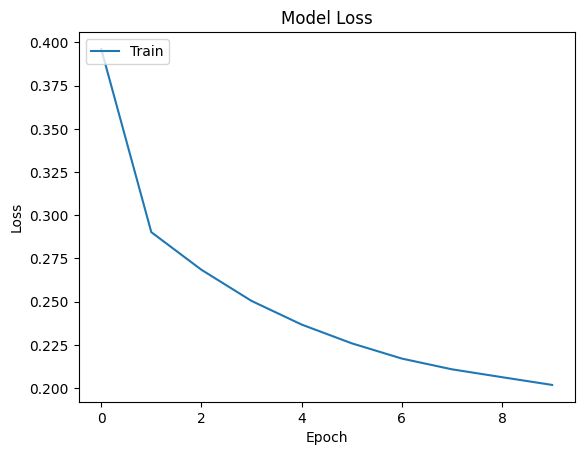

In [8]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [9]:
from tensorflow.keras.models import load_model

# Load the model from the file
model = load_model('cityScapes.keras')

# Assuming you have a validation set prepared similarly to the training dataset:
image_files_val, annotation_files_val = get_matched_files(
    image_dir='/home/maith/Desktop/Cityscapes/leftImg8bit_trainvaltest/val',
    annotation_dir='/home/maith/Desktop/Cityscapes/gtFine_trainvaltest',
    img_suffix='_leftImg8bit.png',
    ann_suffix='_gtFine_color.png'
)
validation_dataset = create_tf_dataset(image_files_val, annotation_files_val, batch_size=2)

# Load the model if not already in memory (skip if model is still in memory)
# model = tf.keras.models.load_model('cityScapes.keras')

# Evaluate the model on the validation dataset
results = model.evaluate(validation_dataset)
print("Validation Loss: {:.4f}, Validation Accuracy: {:.4%}".format(results[0], results[1]))

# Optionally, for more detailed evaluation, you can use model.predict() on the validation dataset and calculate additional metrics like precision, recall, and F1-score


250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9285 - loss: 0.2285
Validation Loss: 0.2349, Validation Accuracy: 92.6472%
